# Random Forest Interpretation 

In [16]:
2020-7-7 14:52:43 

## Imports

In [72]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [73]:
from fastai.imports import *
from fastai.structured import *

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pandas_summary import DataFrameSummary
from sklearn import metrics
from IPython.display import display
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

sns.set_style('darkgrid')

## Processing Data

In [75]:
df_raw = pd.read_feather('tmp/df_raw1')

In [76]:
df, y, nas = proc_df(df_raw, 'SalePrice', subset=100000)

In [77]:
df.shape, y.shape

((100000, 66), (100000,))

In [78]:
def split(data_set, size):
    return data_set[:size], data_set[size:]
test_size = 12000
size = len(df) - test_size

X_train, X_valid = split(df, size)
y_train, y_valid =  split(y, size)
raw_train, raw_valid = split(df_raw, size)

In [79]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,9.259131,1840702,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401121,6333337,9.305651,1830472,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401122,6333338,9.350102,1887659,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401123,6333341,9.104980,1903570,21435,149,2.0,2005,NaN,NaN,30NX,...,25,1,298,False,False,False,False,False,False,1319500800


In [80]:
X_valid.shape, X_train.shape, y_train.shape

((12000, 66), (88000, 66), (88000,))

## Training a model

In [81]:
def rmse(actuals, predicted):
    '''Returns the root mean square log error between the actual value and predicted value '''
    return np.sqrt(mean_squared_error(actuals, predicted))

def print_score(model):
    '''Prints out a series of score about the model passed 
    
    score
    =====
    The R^2 score of the training or validation set
    
    rmse
    ====
    The root mean square log error between the actual price and the predicted price
    '''
    scores = [rmse(y_train , model.predict(X_train)), rmse(y_valid, model.predict(X_valid)),
              model.score(X_train, y_train), model.score(X_valid, y_valid)
            ]
    print(f'The rmse of the train set : {scores[0]}')
    print(f'The rmse of the validation set : {scores[1]}')
    print(f'The score of the train set : {scores[2]}')
    print(f'The score of the validation set : {scores[3]}')

    # adding the oob_score
    if hasattr(model, 'oob_score_'):
        scores.append(model.oob_score_)
        print(f'The OOB_score : {scores[4]}')

In [82]:
rf = RandomForestRegressor(n_estimators=40, max_features=0.5,
                           min_samples_leaf=3, oob_score=True, n_jobs=-1)
rf.fit(X_train, y_train)
print_score(rf)

The rmse of the train set : 0.131819604799707
The rmse of the validation set : 0.26953353967811977
The score of the train set : 0.9631536666029288
The score of the validation set : 0.8656843857809882
The OOB_score : 0.8857240466563893


# Interpretation

## Confidence based on tree variance

In [101]:
set_rf_samples(50000)

In [84]:
preds = np.stack([t.predict(X_valid) for t in rf.estimators_])
np.mean(preds[:,0]), np.std(preds[:, 0])

(10.998660470565383, 0.2557028195599826)

In [85]:
def get_predict(t):
    return t.predict(X_valid)
preds = np.stack(parallel_trees(rf, get_predict))
preds[:,0].mean(), np.std(preds[:,0])

(10.998660470565383, 0.2557028195599826)

In [86]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds[:, 0])
x['pred'] = np.mean(preds[:, 0])

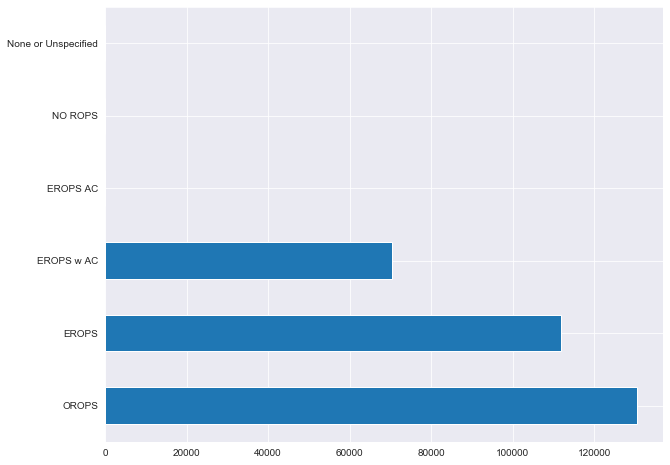

In [87]:
x.Enclosure.value_counts().plot.barh(figsize=(10, 8))
plt.show()

In [88]:
fld = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
x[fld].groupby('Enclosure', as_index=False).mean()

,Enclosure,SalePrice,pred,pred_std
0,EROPS,10.058795,10.99866,0.255703
1,EROPS AC,9.852914,10.99866,0.255703
2,EROPS w AC,10.693282,10.99866,0.255703
3,NO ROPS,10.697825,10.99866,0.255703
4,None or Unspecified,9.699503,10.99866,0.255703
5,OROPS,9.810282,10.99866,0.255703


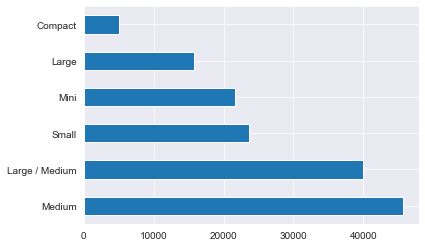

In [89]:
x.ProductSize.value_counts().plot.barh()
plt.show()

In [90]:
flds = ['pred_std', 'pred', 'ProductSize', 'SalePrice']
summ = x[flds].groupby('ProductSize').mean()
summ

,pred_std,pred,SalePrice
ProductSize,,,
Compact,0.255703,10.99866,9.669399
Large,0.255703,10.99866,10.427667
Large / Medium,0.255703,10.99866,10.631128
Medium,0.255703,10.99866,10.531843
Mini,0.255703,10.99866,9.519885
Small,0.255703,10.99866,10.260832


## Feature Importance

In [91]:
fi = rf_feat_importance(rf, df)
fi[:10]

,cols,imp
5,YearMade,0.180587
37,Coupler_System,0.116093
13,ProductSize,0.109986
14,fiProductClassDesc,0.068707
2,ModelID,0.060660
63,saleElapsed,0.051862
10,fiSecondaryDesc,0.044187
38,Grouser_Tracks,0.041647
8,fiModelDesc,0.035043
19,Enclosure,0.032650


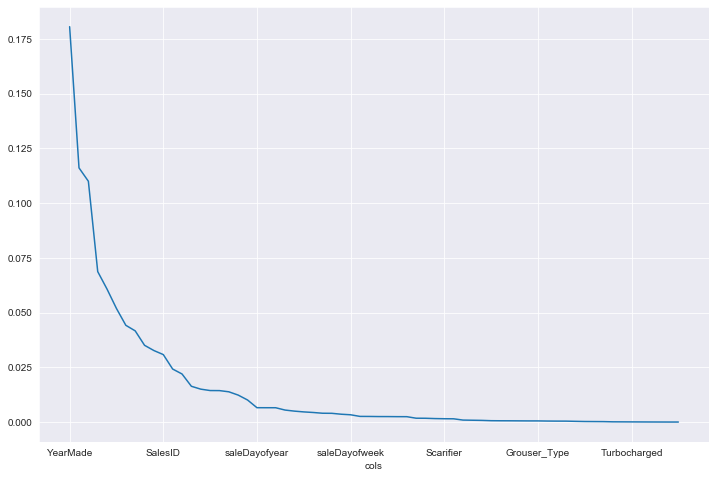

In [92]:
fi.plot('cols', 'imp', figsize=(12, 8), legend=False)
plt.show()

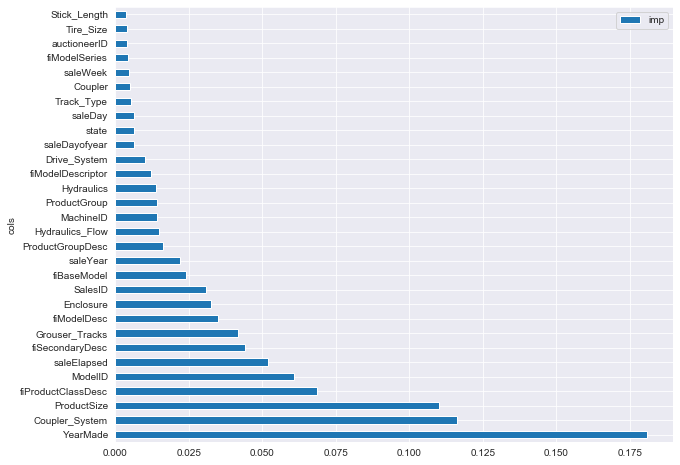

In [93]:
fi[:30].plot.barh('cols', 'imp', figsize=(10, 8))
plt.show()

In [116]:
to_keep = fi[fi.imp > 0.005].cols
len(to_keep)

20

In [117]:
df_keep = df[to_keep].copy()
X_train, X_valid = split(df_keep, size)

In [118]:
rf = RandomForestRegressor(n_estimators=40, max_features=0.5,
                           min_samples_leaf=3, oob_score=True, n_jobs=-1).fit(X_train, y_train)
print_score(rf)

The rmse of the train set : 0.14095792777054933
The rmse of the validation set : 0.27266380696387926
The score of the train set : 0.957867883156624
The score of the validation set : 0.8625464815604831
The OOB_score : 0.8862551337300549


In [119]:
fi = rf_feat_importance(rf, df_keep)
fi[:10]

,cols,imp
0,YearMade,0.177596
2,ProductSize,0.116813
1,Coupler_System,0.094579
3,fiProductClassDesc,0.078904
4,ModelID,0.063135
5,saleElapsed,0.057785
7,fiSecondaryDesc,0.052262
8,Hydraulics_Flow,0.045783
6,Grouser_Tracks,0.043932
9,Enclosure,0.039811


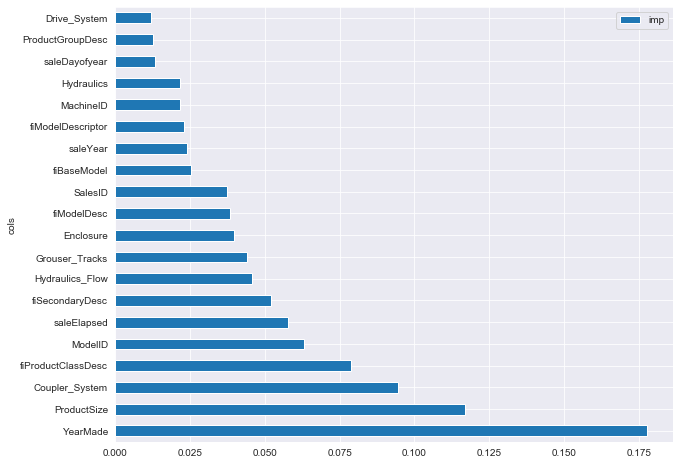

In [120]:
fi.plot.barh('cols', 'imp', figsize=(10,8))
plt.show()